# PyGrid: Remote Inference

<img src="../../../docs/img/pygrid_logo.png" align="center"/>
Evaluate custom models using private datasets without even having access to them is a powerfull resource that can change the way we interact with data during a machine learning workflow, PySyft and PyGrid offers the ability to run inferences remotely by using a variety of technologies and applications.

In this notebook, we'll be covering all the nuances of this process, showing how to send private datasets _(as data owner)_, how to perform remote computation using private environments _(as data scientist)_ and the most important: **How to make private data _"accessible"_ while we empowering data owners with total control of their data.**

## 1 - Host a private dataset as a Data Owner
The first step in this workflow is to send a private dataset to the domain. We can do it using two different approaches:

- **Tensor Data Structures**: Using the torch tensor structures and the default PySyft API
- **Structured and compressed CSV folder** : We can upload a _.tar.gz_ file  by using the PyGrid API.

This notebook aims to cover the second approach. Here, we'll be sending a compressed file containing a structured folder with different CSV files + metadata information about the dataset _(manifest, description and tags)_. These informations will be useful to understand the data structure even without having access to the data values by itself.<br>

### 1.1 - Import dependencies
As usual, we need to import the syft dependencies to go through this process.

In [1]:
from syft.grid.client.client import connect # Method used to connect with the node.
from syft.grid.client.grid_connection import GridHTTPConnection # Protocol used to talk with the node

import syft as sy
import torch as th

# Set logging level
import logging
logging.basicConfig(level=logging.INFO)

sy.VERBOSE = False

### 1.2 Connecting using  data owner account credentials
As a **data owner**, we need to connect using the proper credentials. 
<br><br>
_PS: If you don't know how to create user accounts, i'd sugest to read this [notebook](https://github.com/OpenMined/PySyft/blob/pygrid_demo/examples/pygrid/user/User%20Client%20API.ipynb)_

In [2]:
data_owner = connect(
    url="http://localhost:5000", # Domain Address
    credentials={"email":"dataowner@email.com", "password":"user3pwd"},
    conn_type= GridHTTPConnection,) # HTTP Connection Protocol

***From now on, all the requests made by the data owner will be sent using the "data_owner" grid client.***

### 1.3 Hosting a dataset
In this section we want to cover the process of host a dataset as a ***data owner*** and also how can we use its metadata to understand the dataset structure.

#### 1.3.1 - Uploading a dataset
The next step is to upload our compressed file in the domain node. To acomplish that, we need to specify the proper path where the file lives. 

_PS1: At the time this article has been written, PyGrid platform offers support for .tag.gz only._<br>
_PS2: If you don't know how to struct your files or what can you do using PyGrid Dataset structures, i'd sugest to read this [notebook](http://github.com/OpenMined/PySyft.git))_

In [3]:
dataset = data_owner.datasets.create("diabetes-data.tar.gz")

_Vioalá_, we have the dataset uploaded in our domain node.This method will return a dataset structure, which can be used to explore/use the dataset pointers remotely.

#### 1.3.2 - Understanding the uploaded dataset
Now, let's take a look at our dataset to understand how the dataset is structured.

In [4]:
dataset.pandas

,name,id,tags,dtype,shape
0,diabetes_data/data_02.csv,f20212bc-f435-46ab-b944-06a99dde9b7f,"[#diabetes, #pima-indians-database, #data_02.csv]",Tensor,"(200, 9)"
1,diabetes_data/data_06.csv,055542f1-71d1-49ef-85a4-a9dd80e56591,"[#diabetes, #pima-indians-database, #data_06.csv]",Tensor,"(200, 9)"
2,diabetes_data/data_10.csv,d6a59557-97d0-45cf-9821-36d25150f941,"[#diabetes, #pima-indians-database, #data_10.csv]",Tensor,"(1, 9)"
3,diabetes_data/data_03.csv,caabb3c3-7b8d-471c-a9b9-84779933a39f,"[#diabetes, #pima-indians-database, #data_03.csv]",Tensor,"(200, 9)"
4,diabetes_data/data_04.csv,d6f58579-da35-41a8-b3c9-09201543c2a2,"[#diabetes, #pima-indians-database, #data_04.csv]",Tensor,"(200, 9)"
5,diabetes_data/data_07.csv,fc063944-ee58-4837-86ad-12dc850d400e,"[#diabetes, #pima-indians-database, #data_07.csv]",Tensor,"(200, 9)"
6,diabetes_data/data_08.csv,8ee0067c-d9d6-449e-a0e5-630a6f6bc197,"[#diabetes, #pima-indians-database, #data_08.csv]",Tensor,"(200, 9)"
7,diabetes_data/data_09.csv,2e4bdd7f-2779-47d3-8624-dee69001fee9,"[#diabetes, #pima-indians-database, #data_09.csv]",Tensor,"(200, 9)"
8,diabetes_data/data_05.csv,a8f761ee-8c08-4e57-bf2a-bd600248d591,"[#diabetes, #pima-indians-database, #data_05.csv]",Tensor,"(200, 9)"
9,diabetes_data/data_00.csv,22fe8ee8-b21d-4419-a85b-b5aa9f8d8266,"[#diabetes, #pima-indians-database, #data_00.csv]",Tensor,"(199, 9)"


Done! Now we have a dataset hosted and documented properly.From now on, data scientists and machine learning researchers will be able to search by this data just by querying one of these tags.

## 2 - Run Remote Inferences as a Data Scientist

Now, let's explore the **data scientist** perspective!<br><br>As a data scientist/machine learning researcher, we're insterested in use the private data to evaluate our models or even train a new one improving its accuracy. But since we can't access them directly we must follow several steps to run remote inferences using them.These steps are briefly described in the list below and will be covered during the next sections.

- ***Train a model***: Train a model locally using the same features as the private dataset.
- ***Create a private environment***: Ask for the domain to create a new worker instance to run our computations.
- ***Load the private dataset***: Load the private dataset from the domain node to our private environment.
- **Send your trained model**: Send our local pre-trained model trained our remote worker instance.
- **Run model Inference**: Run remote inference, controlling both model and private datasets by using pointers.

### 2.1 Connecting using  data scientist account credentials
As a **data scientist**, we need to connect using the proper credentials.

In [5]:
data_scientist = connect(
    url="http://localhost:5000", # Domain Address
    credentials={"email":"user@email.com", "password":"user2pwd"},
    conn_type= GridHTTPConnection,) # HTTP Connection Protocol

**From now on, all the requests made by the data scientist will be sent by using the "data_scientist" grid client.**

### 2.2 Check for available datasets
Since we still don't have a proper struct that points to the desired dataset, we need to check for available datasets by looking at the domain store.

In [6]:
data_scientist.datasets.all(pandas=True)

,id,manifest,description,tags,data
0,46da3889-0dc1-47b8-9637-04ac01772581,This dataset is originally from the National I...,This dataset is originally from the National I...,"[#diabetes, #pima-indians-database]","[{'name': 'diabetes_data/data_02.csv', 'id': '..."


In [7]:
dataset = data_scientist.datasets["46da3889-0dc1-47b8-9637-04ac01772581"]

Now we have a structure that points to the same dataset uploaded by the data owner.

### 2.3 Checking the dataset metadata

As a **data scientist**, have never seen this dataset before and we cannot access it directly. To understand how the data is structured and its purposes we need to use the documentation attached to them.

In [8]:
print(dataset.manifest)

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Diabetes files consist of 8 fields per record.  Each field is
separated by a comma and each record is separated by a newline.

CSV Columns and format:
(1) Pregnancies (Integer) : Number of times pregnant
(2) Glucose (Integer) : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
(3) Blood Pressure (Integer) : Diastolic blood pressure (mm Hg)
(4) Skin Thickness (Integer) : Triceps skin fold thickness (mm)
(5) Insulin (Integer) : 2-Hour serum insulin (mu U/ml)
(6) BMI (Float) : Body mass index (weight in kg/(height in m)^2)
(6) Diabetes Pedigree (Float) : Diabetes Pedigree Function
(7) Age (In

Reading this manifest document, we can understand the meaning of each column and also get some information about its purposes.

### 2.5 - Configuring a compute environment 
In order to perform remote computing we also need to create a custom and private environment. These environments are ephemeral, attached to your account and will be used by you to perform any computation intended. So, let's create a new environment!

#### 2.5.1 - Check available instances
Since we'll be creating a new Virtual Machine it's necessary to check what vm instances are available in our cloud service.

In [9]:
#domain.workers.instance_type(pandas=True)

#### 2.5.2 - Create a new Virtual Machine
Once we decided about our vm instance, we can request for the domain node to create one for us.

In [10]:
data_scientist.workers.create(instance_type="t2.large")

INFO:root:Worker created successfully!


#### 2.5.3 - Checking my current environments
We can also check if we have other environments created and their respective informations.

In [11]:
data_scientist.workers.all(pandas=True)

,id,state,provider,region,instance_type,address,created_at,destroyed_at
0,1,2,Azure,sa-sao_paulo,local_instance,localhost:5001,2021-04-23 23:22:38.037624,2021-04-23 23:18:26.171166


#### 2.5.4 - Getting a environment proxy

As mentioned above, these instances are different machines deployed in a cloud platform. Since they'll be carrying private data, you will not being able access or talk to them directly. So, in order to be able to send commands to, we'll be using client proxies. These proxies will be forwarding our messages to these machines through the domain.<br><br>In short: If we want to send a command to the domain itself we can do it by using our **data_scientist** client, if we want to send a proxy message for one of our private environments we can do it by using the **domain.workers[env_index]**

In [13]:
worker = data_scientist.workers[1]

In [14]:
print("Worker provider: ", worker.provider)
print("Worker provider: ", worker.state) # 2 == active
print("Worker provider: ", worker.region)
print("Worker provider: ", worker.instance_type)
print("Worker provider: ", worker.address) # Syft Logic Address, not the URI.
print("Worker provider: ", worker.created_at)
print("Worker provider: ", worker.destroyed_at)# if destroyed_at ~= current time, vm hasn't been destroyed yet

Worker provider:  Azure
Worker provider:  2
Worker provider:  sa-sao_paulo
Worker provider:  local_instance
Worker provider:  <Address - Domain:<SpecificLocation:..72a6f>>
Worker provider:  2021-04-23 23:22:38.037624
Worker provider:  2021-04-23 23:18:26.171166


#### 2.5.6 - Load the private dataset

Ok, now we have the environment defined, the question is: how do we manage to send the data stored in the domain to these environments without accessing them? The answer is: **_data_scientist.load_**.<br><br>

This method will make the domain send an specific data to our own environment. In our use case scenario, we want to use the diabetes datasets uploaded by the data_scientist.

In [15]:
print( "Dataset Name: ", dataset.files[0].name )
print( "Dataset Shape: ", dataset.files[0].shape )
print( "Dataset Type: ", dataset.files[0].dtype )
print( "Dataset Pointer: ", dataset.files[0].pointer )

Dataset Name:  diabetes_data/data_02.csv
Dataset Shape:  (200, 9)
Dataset Type:  Tensor
Dataset Pointer:  <syft.proxy.torch.TensorPointer object at 0x7f5456cdb9a0>


In [16]:
data_scientist.load(dataset.files[0].pointer, worker.address)

#### 2.5.7 Checking your environment store
Now we want to check if the data arrived in our environment. We can do it by checking the environment store.

In [17]:
worker.store.pandas

,ID,Tags,Description,object_type
0,<UID: 82fab1db68244b31b55a282482c9c683>,"[#diabetes, #pima-indians-database, #data_02.csv]",,<class 'torch.Tensor'>


#### 2.5.8 - Performing remote computations using remote data.

The data we sent has (200, 9) as its dimensions, but according to the manifest document, the last column does not represent a feature, but the labels of the dataset. To be able to run inferences properly, we must first remove this column. <br> <br> The cool thing about this step is: **once we're in our private environment, we can compute this using the same code as if we had this data stored locally!**

In [18]:
sliced_dataset = worker.store[0][0:,0:8] # These slices consider all the rows and excludes the last column

As you can see, remote operations will generate new pointers  as a result

In [19]:
sliced_dataset

## 3 - Train a model and run remote inferences
Ok, now we have remote environment prepared to perform computations using a private dataset. It's time to train our custom model locally using our own data.<br>

### 3.1 - Train a local model
_PS: The training process has been implemented in a different source file since this isn't the focus of this notebook, but feel free to check it out later._

epoch 0	loss : 0.661741316318512	 accuracy : 0.6605
epoch 50	loss : 0.4892537295818329	 accuracy : 0.7825
epoch 100	loss : 0.49179765582084656	 accuracy : 0.7875
epoch 150	loss : 0.4829869568347931	 accuracy : 0.789
epoch 200	loss : 0.47383350133895874	 accuracy : 0.799
epoch 250	loss : 0.46235257387161255	 accuracy : 0.8075


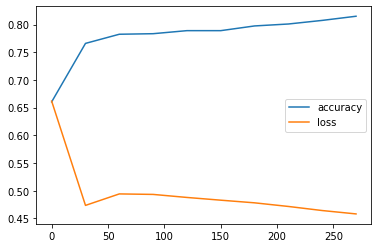

In [20]:
from diabetes_model_training import train_diabetes_model, plot_training_acc
model, loss, acc, epochs_list = train_diabetes_model(th)
plot_training_acc(acc, loss, epochs_list)

### 3.2 - Send the model to the environment
Cool! Now we set the private environment properly, we trained our custom model using our own data. But our local model is still ... local.<br><p>To send it to our environment we'll be using the **_send_** method, if you are familiar with the PySyft API you probably know that the _send_ is commonly used to send a local data to a remote node.<br>The difference here is: The worker is client proxy, so instead of sending it directly, we're sending it through the domain. Therefore, unlike the datasets who remains on the domain node, this model will not be saved there.

In [21]:
remote_model = model.send(worker)

In [22]:
remote_model

<diabetes_model_training.set_model_opt_loss.<locals>.SyNet at 0x7f5456d69070>

### 3.3 - Run Model Inference
***__Finally!__*** If you were able to reach this point you did everything right! Congratulations!<br><br> Now, to run inference using our remote model and dataset we just need to use their respective pointers.

In [23]:
inference_result = remote_model(sliced_dataset)

In [24]:
inference_result

## 4 - Retrieving the computation results
Now we have the inference result in our virtual machine, but we want to get its real values. To acomplish this, we must follow several steps:<br>

- **Save inference result**: Transfer the result value from the private environments to the domain.
- **Delete the worker instance**: Delete the worker instance deployed to create the environment.
- **Request data access**: In order to be able to get the results, we need to ask for get permission for the data owner.
- **Data triage**: The data owner who hosted the dataset, will receive data access request and inspect it allowing or denying its access.
- **Retrieve the inference result**: If the data owner approves the result retrieval, we can now recover it from the domain.

### 4.1 - Saving the inference result
Since our environments are ephemeral and we can't recover any data directly from them, we need to send it back to the domain node.

In [25]:
worker.save(inference_result)

We can check if the inference result has arrived by checking the domain store

In [26]:
data_scientist.store.pandas

,ID,Tags,Description,object_type
0,<UID: 055542f171d149ef85a4a9dd80e56591>,"[#diabetes, #pima-indians-database, #data_06.csv]",,<class 'torch.Tensor'>
1,<UID: 22fe8ee8b21d4419a85bb5aa9f8d8266>,"[#diabetes, #pima-indians-database, #data_00.csv]",,<class 'torch.Tensor'>
2,<UID: 2e4bdd7f277947d38624dee69001fee9>,"[#diabetes, #pima-indians-database, #data_09.csv]",,<class 'torch.Tensor'>
3,<UID: 8ee0067cd9d6449ea0e5630a6f6bc197>,"[#diabetes, #pima-indians-database, #data_08.csv]",,<class 'torch.Tensor'>
4,<UID: a8f761ee8c084e57bf2abd600248d591>,"[#diabetes, #pima-indians-database, #data_05.csv]",,<class 'torch.Tensor'>
5,<UID: bdf186c71b894e7883f3e62271bffcdc>,"[#diabetes, #pima-indians-database, #data_01.csv]",,<class 'torch.Tensor'>
6,<UID: ca722a6370e549928338a05917f827e8>,"[#diabetes, #pima-indians-database, #data_02.c...",,<class 'torch.Tensor'>
7,<UID: caabb3c37b8d471ca9b984779933a39f>,"[#diabetes, #pima-indians-database, #data_03.csv]",,<class 'torch.Tensor'>
8,<UID: d6a5955797d045cf982136d25150f941>,"[#diabetes, #pima-indians-database, #data_10.csv]",,<class 'torch.Tensor'>
9,<UID: d6f58579da3541a8b3c909201543c2a2>,"[#diabetes, #pima-indians-database, #data_04.csv]",,<class 'torch.Tensor'>


### 4.2 - Delete Environment
Since the computing environment will not be used anymore, we can delete it.

In [27]:
del data_scientist.worker[1] # del worker  != del data_scientist.worker[1]

Check if its state has been changed

In [28]:
data_scientist.workers.all(pandas=True)

,id,state,provider,region,instance_type,address,created_at,destroyed_at
0,1,2,Azure,sa-sao_paulo,local_instance,localhost:5001,2021-04-23 23:22:38.037624,2021-04-23 23:18:26.171166


### 4.2 - Data access request

We can make a data access request by using our data pointer stored in the domain

In [29]:
data_scientist.store["ca722a6370e549928338a05917f827e8"].request(reason="I'd like to have my model inference result.")

### 4.3 - Data triage
Now, it's up to the data owner to evaluate the request, allowing or denying it.

In [30]:
data_owner.requests.pandas

,Requested Object's tags,Reason,Request ID,Requested Object's ID,Requested Object's type
0,"[#diabetes, #pima-indians-database, #data_02.c...",I'd like to have my model inference result.,<UID: 751eb51444a3429e8d7b126f38f9a05c>,<UID: ca722a6370e549928338a05917f827e8>,<class 'torch.Tensor'>


A data access request can be accepted/denied by using the request pointer

In [31]:
data_owner.requests[0].accept()

### 4.5 - Retrieving the inference result
Finally, we can retrieve the original values of the inference result.

In [32]:
data_scientist.store["ca722a6370e549928338a05917f827e8"].get()

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

## Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star PySyft and SyMPC on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool tools we're building.

* [Star PySyft](https://github.com/OpenMined/PySyft)
* [Star PyGrid](https://github.com/OpenMined/PyGrid)

### Join our Slack!
The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at http://slack.openmined.org

### Join a Code Project!
The best way to contribute to our community is to become a code contributor! At any time you can go to PySyft GitHub Issues page and filter for "Projects". This will show you all the top level Tickets giving an overview of what projects you can join! If you don't want to join a project, but you would like to do a bit of coding, you can also look for more "one off" mini-projects by searching for GitHub issues marked "good first issue".

* [PySyft Good First Issue Tickets](https://github.com/OpenMined/PySyft/labels/Good%20first%20issue%20%3Amortar_board%3A)
* [PyGrid Good First Issue Tickets](https://github.com/OpenMined/PyGrid/labels/good%20first%20issue)

### Donate
If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

* [OpenMined's Open Collective Page](https://opencollective.com/openmined)